In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
from isaac.dataset import read_dataset, prepare_dataset, prepare_test_dataset, sample_subsequences
from isaac.utils import plot_confusion_matrix
from isaac.models import RNNModel, ComplexRNNModel
from isaac.constants import BASIC_TRAINING_COLS, FORCE_CLASS_COLS, MASS_CLASS_COLS
from isaac.training import evaluate, training_loop

In [12]:
BATCH_SIZE = 128
EPOCHS = 100
TEST_SIZE = 0.2
NORMALISE_DATA = True
STEP_SIZE = 2

# Define common model, loss and optimizer

In [5]:
INPUT_DIM = len(BASIC_TRAINING_COLS)    # input dimension
HIDDEN_DIM = 20  # hidden layer dimension
N_LAYERS = 3     # number of hidden layers
OUTPUT_DIM = 3   # output dimension
DROPOUT = 0.5

def initialise_model():
    np.random.seed(0)
    torch.manual_seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    model = ComplexRNNModel(INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, dropout=DROPOUT)
    model = model.cuda()

    error = nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    return model, error, optimizer

# MASS TRAINING (Humans achieve 46% +- 29%)

## Read dataset and preprocess it

In [6]:
all_trials = read_dataset("data/train_passive_trials.h5", n_trials=3000)

100%|██████████| 3000/3000 [00:13<00:00, 226.52it/s]


In [7]:
train_loader, val_loader, scaler = prepare_dataset(all_trials, class_columns=MASS_CLASS_COLS, 
                                                   batch_size=BATCH_SIZE, normalise_data=NORMALISE_DATA, 
                                                   test_size=TEST_SIZE)

100%|██████████| 3000/3000 [00:02<00:00, 1088.84it/s]


In [8]:
Y = []
for x,y in train_loader:
    
    Y.extend(list(y))

counts = np.unique(Y, return_counts=True)[1]

In [9]:
counts

array([791, 788, 821])

In [10]:
print("Majority class: ", np.max(counts) / np.sum(counts))

Majority class:  0.34208333333333335


## Define model, loss and optimizer

In [11]:
model, error, optimizer = initialise_model()

## Train model and plot loss and accuracy

In [13]:
epoch_losses, epoch_accuracies, best_model = training_loop(model, optimizer, error, train_loader, val_loader, EPOCHS,
                                                          step_size=STEP_SIZE)

Train_loss (0.16)	 Train_acc (91.21)	 Val_acc (66.83): 100%|██████████| 100/100 [08:47<00:00,  6.08s/it]


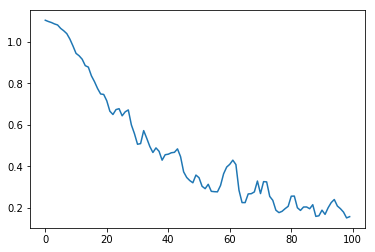

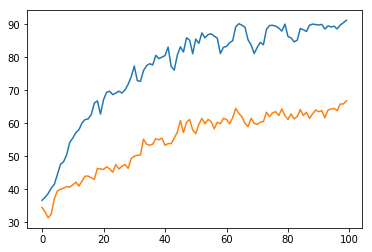

In [14]:
plt.plot(epoch_losses)
plt.show()
plt.plot(np.array(epoch_accuracies).T)
plt.show()

In [15]:
max(epoch_accuracies[1])

66.83333333333333

## Save model and scaler

In [16]:
torch.save(best_model.state_dict(), "models/passive_mass_model.pt")

In [17]:
joblib.dump(scaler, "scalers/passive_mass_scaler.sk")

['scalers/passive_mass_scaler.sk']

## Load model and evaluate

In [18]:
scaler = joblib.load("scalers/passive_mass_scaler.sk")

In [20]:
model = ComplexRNNModel(INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM)
model.load_state_dict(torch.load("models/passive_mass_model.pt"))
model.eval()
model = model.cuda()

In [21]:
all_trials = read_dataset("data/test_passive_trials.h5")
test_loader = prepare_test_dataset(all_trials, MASS_CLASS_COLS, scaler=scaler)

100%|██████████| 500/500 [00:00<00:00, 1010.50it/s]


In [23]:
accuracy, predicted = evaluate(model, test_loader, return_predicted=True, step_size=STEP_SIZE)

In [24]:
print(accuracy)

52.0


In [25]:
predicted = [pred.cpu() for pred in predicted]
Y_test = np.concatenate([y.cpu().numpy() for x, y in test_loader])

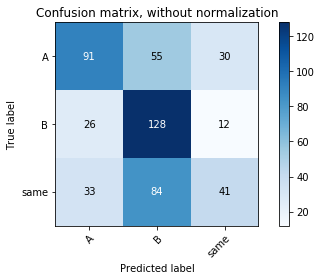

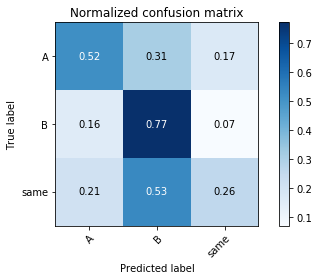

In [26]:
plot_confusion_matrix(Y_test, predicted, classes=MASS_CLASS_COLS, normalize=False)
plot_confusion_matrix(Y_test, predicted, classes=MASS_CLASS_COLS, normalize=True)

# FORCE TRAINING  (Humans achieve 61% +- 22%)

## Read dataset and preprocess it

In [27]:
all_trials = read_dataset("data/train_passive_trials.h5", n_trials=3000)
train_loader, val_loader, scaler = prepare_dataset(all_trials, class_columns=FORCE_CLASS_COLS, 
                                                   batch_size=BATCH_SIZE, normalise_data=NORMALISE_DATA, 
                                                   test_size=TEST_SIZE)

100%|██████████| 3000/3000 [00:03<00:00, 978.08it/s] 


In [28]:
Y = []
for x,y in train_loader:
    
    Y.extend(list(y))

counts = np.unique(Y, return_counts=True)[1]

In [29]:
print("Majority class: ", np.max(counts) / np.sum(counts))

Majority class:  0.3408333333333333


## Define model, loss and optimizer

In [30]:
model, error, optimizer = initialise_model()

## Train model and plot loss and accuracy

In [31]:
model.train()
epoch_losses, epoch_accuracies, best_model = training_loop(model, optimizer, error, train_loader, val_loader, EPOCHS, step_size=STEP_SIZE)

Train_loss (0.04)	 Train_acc (89.38)	 Val_acc (80.67): 100%|██████████| 100/100 [10:40<00:00,  6.39s/it]


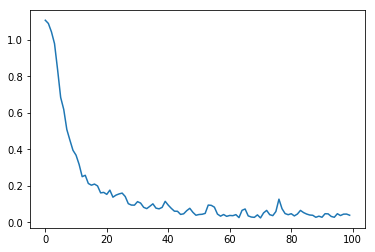

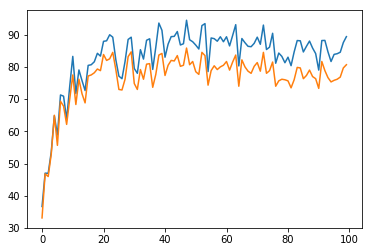

In [32]:
plt.plot(epoch_losses)
plt.show()
plt.plot(np.array(epoch_accuracies).T)
plt.show()

In [33]:
max(epoch_accuracies[1])

85.83333333333333

## Save model and scaler

In [34]:
torch.save(best_model.state_dict(), "models/passive_force_model.pt")

In [35]:
joblib.dump(scaler, "scalers/passive_force_scaler.sk")

['scalers/passive_force_scaler.sk']

## Load model and evaluate

In [36]:
scaler = joblib.load("scalers/passive_force_scaler.sk")

In [37]:
model = ComplexRNNModel(INPUT_DIM, HIDDEN_DIM, N_LAYERS, output_dim)
model.load_state_dict(torch.load("models/passive_force_model.pt"))
model.eval()
model = model.cuda()

NameError: name 'input_dim' is not defined

In [ ]:
all_trials = read_dataset("data/test_passive_trials.h5")
test_loader = prepare_test_dataset(all_trials, FORCE_CLASS_COLS, scaler=scaler)

In [ ]:
accuracy, predicted = evaluate(model, test_loader, return_predicted=True, step_size=2)

In [ ]:
print(accuracy)

In [ ]:
predicted = [pred.cpu() for pred in predicted]
Y_test = np.concatenate([y.cpu().numpy() for x, y in test_loader])

In [ ]:
plot_confusion_matrix(Y_test, predicted, classes=FORCE_CLASS_COLS, normalize=False)
plot_confusion_matrix(Y_test, predicted, classes=FORCE_CLASS_COLS, normalize=True)